# Noisy Cosine Function Fitting with a Quantum Neural Network

Using the example from Penny Lane of a variational circuit that learns a
fit for a noisy cosine function. 

The variational circuit used is the continuous-variable quantum neural
network model described in:

`Killoran et al. (2018) <https://arxiv.org/abs/1806.06871>`


In [1]:
# Import PennyLane, the wrapped version of NumPy provided by PennyLane,and an optimizer.
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

In [2]:
# Other imports:
# matplotlib.pyplot to plot and visualize the data
# numpy to generate the mathematical function
# pylab to help with interactive plots
# pickle to dump the data into a file for future use
import matplotlib.pyplot as plt
import numpy as np
import pylab
import pickle

## Creating a Noisy Cosine Function for Sampling

In [3]:
Xlim = 2
noise = np.random.normal(0,0.2,40) # generate noise to add to the function values (Y-values)
# define functions
X = np.arange(-Xlim, Xlim, 0.1)
Y = (np.cos(3*X)+noise)/2

This will generate two lists 'X' and 'Y' with our X-axis and Y-axis data. We'll now dump the Y-axis data into our file for future use.

In [4]:
# write the data out to a file
cosdata = open('cosdata.md', 'wb')
pickle.dump(Y, cosdata)
cosdata.close()

The above snippet writes the data of y into a file named sinedata.md. Pickle is specific to Python and it can be used to load the data into another Python script later. Now we plot some of the data:

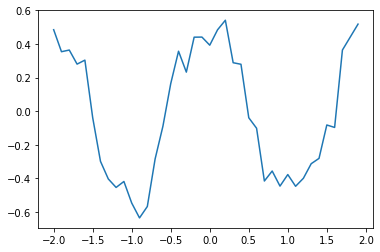

In [5]:
plt.plot(X[0:200], Y[0:200])

So we have some noisy sine data to train our quantum neural network on. The device we use is the Strawberry Fields simulator, this time with only one quantum mode (or ``wire``). You will need to have the Strawberry Fields plugin for PennyLane installed.

In [6]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

### Quantum node
For a single quantum mode, each layer of the variational circuit is defined as:

In [7]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.

In [8]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

### Objective
As an objective we take the square loss between target labels and model
predictions.

In [9]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).


In [10]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

### Optimization
We load noisy data samples of a sine function.

Before training a model, let’s examine the data.

*Note: For the next cell to work you need the matplotlib library.*


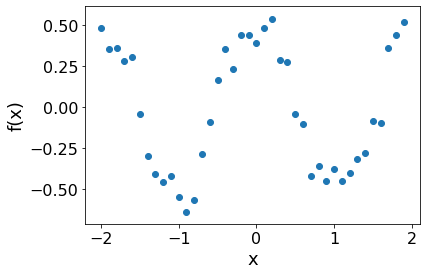

In [11]:
plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

The network’s weights (called ``var`` here) are initialized with values
sampled from a normal distribution. We use 4 layers; performance has
been found to plateau at around 6 layers.

In [12]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


In [13]:
opt = AdamOptimizer(0.05, beta1=0.9, beta2=0.999)

var = var_init
for it in range(100):
    var = opt.step(lambda v: cost(v, X, Y), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 0.8007706 
Iter:     2 | Cost: 0.4914594 
Iter:     3 | Cost: 0.6969488 
Iter:     4 | Cost: 0.9452574 
Iter:     5 | Cost: 1.1168969 
Iter:     6 | Cost: 1.2109571 
Iter:     7 | Cost: 1.2476765 
Iter:     8 | Cost: 1.2450811 
Iter:     9 | Cost: 1.2163145 
Iter:    10 | Cost: 1.1705946 
Iter:    11 | Cost: 1.1142030 
Iter:    12 | Cost: 1.0512289 
Iter:    13 | Cost: 0.9842209 
Iter:    14 | Cost: 0.9147676 
Iter:    15 | Cost: 0.8439298 
Iter:    16 | Cost: 0.7724923 
Iter:    17 | Cost: 0.7010800 
Iter:    18 | Cost: 0.6302264 
Iter:    19 | Cost: 0.5604551 
Iter:    20 | Cost: 0.4923870 
Iter:    21 | Cost: 0.4268471 
Iter:    22 | Cost: 0.3649378 
Iter:    23 | Cost: 0.3080507 
Iter:    24 | Cost: 0.2577916 
Iter:    25 | Cost: 0.2157890 
Iter:    26 | Cost: 0.1833700 
Iter:    27 | Cost: 0.1611441 
Iter:    28 | Cost: 0.1486269 
Iter:    29 | Cost: 0.1441018 
Iter:    30 | Cost: 0.1448548 
Iter:    31 | Cost: 0.1477444 
Iter:    32 | Cost: 0.1498896 
Iter:   

Finally, we collect the predictions of the trained model for 50 values
in the range $[-1,1]$:

In [14]:
x_pred = np.linspace(-1, 1, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

and plot the shape of the function that the model has “learned” from
the noisy data (red dots).

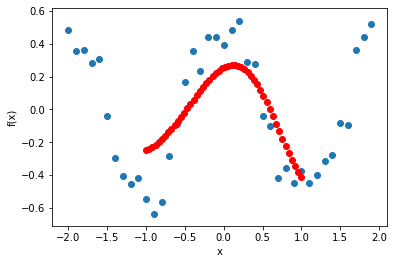

In [15]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

Now we plot the shape of the function that the model has “learned” from
the noisy data (red dots) for 100 values betw

In [19]:
x_pred = np.linspace(-2, 2, 100)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

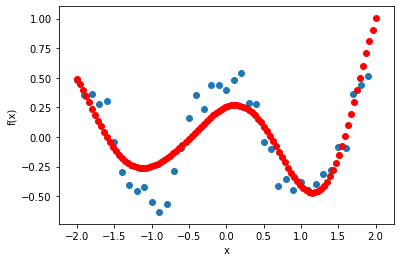

In [20]:
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="red")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

The model has learned to smooth the noisy cosine function.

In fact, we can use PennyLane to look at typical functions that the
model produces without being trained at all. The shape of these
functions varies significantly with the variance hyperparameter for the
weight initialization.

Setting this hyperparameter to a small value produces almost linear
functions, since all quantum gates in the variational circuit
approximately perform the identity transformation in that case. Larger
values produce smoothly oscillating functions with a period that depends
on the number of layers used (generically, the more layers, the smaller
the period).

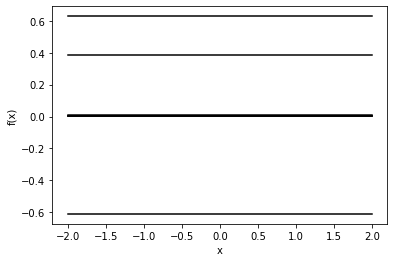

In [16]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-2, 2, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

## References
PennyLane "Function Fitting with a Quantum Neural Network" ```https://pennylane.ai/qml/app/quantum_neural_net.html```

"Generating and visualizing data from a sine wave in Python" ```https://goelhardik.github.io/2016/05/25/sampling-sine-wave/```

`Killoran et al. (2018) <https://arxiv.org/abs/1806.06871>`

"adding noise to a signal in python" ```https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python```